<font size="5">
 <div class="alert alert-block alert-info"> <b>Week 7: Deep Neural Networks (DNNs)<b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  
  
  <font size="3"> **Filipe R. Ramos** </font>
      
   
  <font size="3"> *frjrs@iscte-iul.pt* </font>  
   
    
  <font size="3">ISCTE-IUL </font>

<font size="5">
    <div class="alert alert-warning" role="alert"> -- Deep Neural Networks -- </div> </font>

## **Agenda**

1. Deep Neural Networks (DNNs): Introduction

2. Recurrent Neural Networks (RNNs)

3. **Long Short-Term Memory** (LSTM)
---------------------


## **References**
- [Chollet, F. (2017)](https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf)

- [Haykin, S. (2009)](https://lps.ufrj.br/~caloba/Livros/Haykin2009.pdf)

- [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/)


## **Exercício 2: Overfitting e Cross-validation com Séries Temporais**

-----------------
**OBJETIVO:** Explorar o conceito de overfitting e como ele se apresenta numa rede LSTM aplicada a séries temporais (compreender como um modelo se pode ajustar "excessivamente" ao conjunto de treino e não generalizar). Para tal, será utilizada uma técnica de validação cruzada específica para séries temporais, o `TimeSeriesSplit`, que respeita a sequência temporal dos dados.

[**Porque não podemos usar k-fold?**]

----------------------

**1. Dividir os dados em treino e validação:**

- **Objetivo:** manter a sequência temporal e permitir uma validação mais realista em previsões futuras.
- **Instruções:** usar `TimeSeriesSplit` do `sklearn.model_selection`, que divide os dados em múltiplas janelas de treino e validação sem os baralhar. Em cada "fold", uma nova parte inicial é usada para treino, e a próxima sequência para validação.

**2. Avaliar o modelo na validação em cada época:**

- **Objetivo:** observar o erro de validação ao longo das épocas para identificar sinais de overfitting.
- **Instruções:** modificar o código de `fit` adicionando `validation_data=(X_val, y_val)`. Isso permitirá acompanhar como o erro de validação pode divergir do erro de treino, indicando se o modelo está a "memorizar" os dados de treino em vez de aprender padrões úteis.

**3. Implementar validação cruzada sequencial com TimeSeriesSplit:**

- **Objetivo:** Avaliar a consistência do modelo em diferentes janelas temporais, observando o comportamento em múltiplos "folds".
- **Instruções:** implementar o `TimeSeriesSplit` no código. Para cada janela de treino, o modelo será ajustado com base nos dados iniciais e validado com base nos dados sequenciais subsequentes. Deve observar-se como o erro de validação varia entre os "folds" e interpretar se o modelo consegue generalizar.



**NOTA:**
**Métricas de Avaliação:**
Utilizar o MAPE (Mean Absolute Percentage Error) para cada "fold", uma métrica que indica a precisão das previsões. Para cada conjunto de validação, calcular o MAPE e observar o desempenho geral do modelo.

# **Import libraries**

In [6]:
### bibliotecas

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import MeanSquaredError

# **Import Data**

MultiIndex([( 'Close', 'AMZN'),
            (  'High', 'AMZN'),
            (   'Low', 'AMZN'),
            (  'Open', 'AMZN'),
            ('Volume', 'AMZN')],
           names=['Price', 'Ticker'])
There are 2955 observations in the training data
There are 2955 observations in the test data


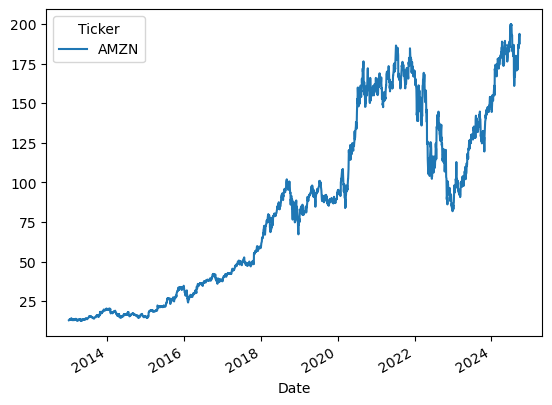

In [7]:
### importar dados do yahoo finance


AMZN = yf.download('AMZN',
                      start='2013-01-01',
                      end='2024-09-30',
                      progress=False)

# AMZN = yf.download('AMZN') for all
# Check the columns of the AMZN DataFrame
print(AMZN.columns)

all_data = AMZN[['Open', 'High', 'Low', 'Close','Volume']].round(2)
all_data.head(10)
print("There are "+ str(all_data[:'2023'].shape[0]) + " observations in the training data")
print("There are "+ str(all_data['2024':].shape[0]) + " observations in the test data")
all_data['Close'].plot()
plt.show()

# **Data Preparation**

In [14]:
### função que faz a divisão em treino-teste, normaliza os dados
### transforma a séries temporal (e os lags) numa dataframe


def ts_train_test_normalize(all_data,time_steps,for_periods):
    '''
    input:
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2023/12/31
      X_test:  data from 2024 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set
    ts_train = all_data.loc[:'2023', ["Close"]].values
    ts_test = all_data.loc['2024':, ["Close"]].values
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)

    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)

    # create training data of s samples and t time steps
    X_train = []
    y_train = []
    y_train_stacked = []
    for i in range(time_steps,ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i,0])
        y_train.append(ts_train_scaled[i:i+for_periods,0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

    inputs = pd.concat((all_data["Close"][:'2023'], all_data["Close"]['2024':]),axis=0).values
    inputs = inputs[len(inputs)-len(ts_test) - time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs  = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(time_steps,ts_test_len+time_steps-for_periods):
        X_test.append(inputs[i-time_steps:i,0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

    return X_train, y_train , X_test, sc

X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
X_train.shape[0],X_train.shape[1]

(2762, 5)

In [ ]:
### função para representar graficamente os valores preditos vs teste

def actual_pred_plot(preds):
    #Plot the actual vs. prediction
    actual_pred = pd.DataFrame(columns = ['Close', 'prediction'])
    actual_pred['Close'] = all_data.loc['2024':,'Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]

    from keras.metrics import MeanSquaredError
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Close']),np.array(actual_pred['prediction']))

    return (m.result().numpy(), actual_pred.plot() )

In [ ]:
# # Convert the 3-D shape of X_train to a data frame so we can see
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0],X_train.shape[1])))
y_train_see = pd.DataFrame(y_train)
pd.concat([X_train_see,y_train_see],axis=1)

# # Convert the 3-D shape of X_test to a data frame so we can see:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0],X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

There are 2762 samples in the training data
There are 185 samples in the test data


# **LSTM Model - Forecasting**

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step 


(31.485222, <Axes: xlabel='Date'>)

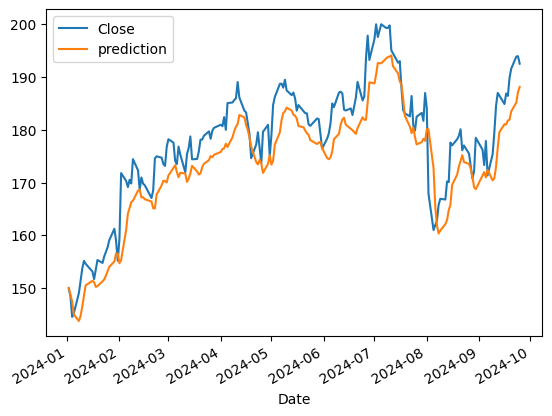

In [ ]:
### função para LSTM


def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Input, Dense, SimpleRNN, GRU, LSTM
    from keras.optimizers import SGD, Adam

    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(Input(shape=(X_train.shape[1],1)))
    my_LSTM_model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_LSTM_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_LSTM_model.add(LSTM(units=50, activation='tanh')) #Como é a última camada LSTM, a rede não precisa mais de uma sequência de saídas, apenas a saída final.
    # Change the Dense layer to predict multiple outputs
    my_LSTM_model.add(Dense(units=y_train.shape[1])) # Adjust the units to match y_train's output shape # Changed 'model' to 'my_LSTM_model'


    # Compiling
    my_LSTM_model.compile(optimizer=Adam(learning_rate=0.01),loss='mean_squared_error')
    # Fitting to the training set
    my_LSTM_model.fit(X_train,y_train,epochs=50,batch_size=150, verbose=0)

    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)

    return my_LSTM_model, LSTM_prediction

X_train, y_train, X_test, sc = ts_train_test_normalize(all_data,5,2)
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
actual_pred_plot(LSTM_prediction)


#Pedir, caso queiram, o vetor das previsões

#print(LSTM_prediction)



In [ ]:
### Calcular métricas de erro relativas à previsão


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

y_test = all_data.loc['2024':,'Close'][0:len(LSTM_prediction)].values
# Select the first column (predicted 'Close' values) from LSTM_prediction
LSTM_prediction_close = LSTM_prediction[:, 0]
mae = mean_absolute_error(y_test, LSTM_prediction_close)
print("Mean Absolute Error (MAE):", mae)

mape = mean_absolute_percentage_error(y_test, LSTM_prediction_close)
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.3f}%")

NameError: name 'all_data' is not defined